# Final Project from "Mining of Massive Datasets" - Romario Stanković 2020230210

**1. Problem identification**
Identification and articulation of a regression and/or classification problem of choice in collaboration with Step 2.

**2. Finding target data**
Publicly available data:
- https://www.kaggle.com/datasets
- https://registry.opendata.aws/
- https://www.reddit.com/r/datasets
- https://data.opendatasoft.com/page/home/
- https://archive.ics.uci.edu/ml/index.php
- or other

**3. Data collection**
Crawling and downloading.

**4. Data analysis and preparation**
Exploratory data analysis using techniques such as integration, transformation, cleaning, filtering, aggregation, etc

**5. Forming model**
Selection and training of the appropriate model(s), given previous steps

**6. Evaluating model**
Calculate, compare, and discuss evaluation metrics typical for chosen model(s

**7. Communicating results**
Visual presentation and comprehensive and critical analysis of the results (oral).

The dataset used in this project is a dataset of laptop specifications and their prices and can be found on the following. The dataset consists of the following **[LINK](https://www.kaggle.com/datasets/arnabchaki/laptop-price-prediction)** columns:

- Manufacturer - The name of the manufacturer of the laptop.
- Model Name - The name of the laptop.
- Category - The category in which the laptop falls.
- Screen Size - The size of the laptop screen in inches.
- Screen - The screen type and resolution.
- CPU - The laptop's CPU.
- RAM - The amount of RAM in the laptop.
- Storage - The size and type of the laptop's storage.
- GPU - The laptop's GPU.
- Operating System - The laptop's operating system.
- Operating System Version - The version of the laptop's operating system if available.
- Weight - The weight of the laptop.
- Price - The price of the laptop in Indian Rupees (INR).

## 0. Setup

In [228]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import countDistinct, count, when, col, udf, split
from pyspark.sql.types import IntegerType, FloatType, BooleanType
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from matplotlib import pyplot as plt
import findspark
import re
import seaborn as sns

In [229]:
# Using findspark to locate the local spark installation on Windows machines
findspark.init()

In [230]:
# Initialize the spark session and get the spark version
spark : SparkSession = SparkSession.builder.master('local').getOrCreate()
spark.version

'3.5.1'

## 1. Data Preprocessing

Data preprocessing is a crucial step in the machine learning pipeline. It is the first step in the process. It involves cleaning and transforming raw data into an understandable format for machine learning models. In this step, we will load the data, check for missing values, convert values to the appropriate data types, and encode categorical variables.

### 1.1. Loading the data

To do anything with our data, we first need to load it into a PySpark DataFrame. This DataFrame is similar to a table in a relational database and allows us to perform SQL-like queries on the data.

In [231]:
# Load the dataset into a spark DataFrame
data = spark.read.csv('laptops.csv', header=True)

In [232]:
# Show the data
data.show()

+------------+-----------------+---------+-----------+--------------------+--------------------+----+-------------------+--------------------+----------------+------------------------+------+-----------+
|Manufacturer|       Model Name| Category|Screen Size|              Screen|                 CPU| RAM|            Storage|                 GPU|Operating System|Operating System Version|Weight|      Price|
+------------+-----------------+---------+-----------+--------------------+--------------------+----+-------------------+--------------------+----------------+------------------------+------+-----------+
|       Apple|      MacBook Pro|Ultrabook|     13.3""|IPS Panel Retina ...|Intel Core i5 2.3GHz| 8GB|          128GB SSD|Intel Iris Plus G...|           macOS|                    NULL|1.37kg|11912523.48|
|       Apple|      Macbook Air|Ultrabook|     13.3""|            1440x900|Intel Core i5 1.8GHz| 8GB|128GB Flash Storage|Intel HD Graphics...|           macOS|                    NULL|

In [233]:
# Print out the schema of the data
data.printSchema()

root
 |-- Manufacturer: string (nullable = true)
 |-- Model Name: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Screen Size: string (nullable = true)
 |-- Screen: string (nullable = true)
 |-- CPU: string (nullable = true)
 |-- RAM: string (nullable = true)
 |-- Storage: string (nullable = true)
 |-- GPU: string (nullable = true)
 |-- Operating System: string (nullable = true)
 |-- Operating System Version: string (nullable = true)
 |-- Weight: string (nullable = true)
 |-- Price: string (nullable = true)



### 1.2. Data analysis

Data analysis helps us understand the data better. In this step, we will check the data types of each column and how many missing and unique values exist in each column

In [234]:
# Show how many distinct (unique) values are in each column
data.agg(
    *(
        countDistinct(c)
        .alias(c)
        for c in data.columns
    )
).show()

+------------+----------+--------+-----------+------+---+---+-------+---+----------------+------------------------+------+-----+
|Manufacturer|Model Name|Category|Screen Size|Screen|CPU|RAM|Storage|GPU|Operating System|Operating System Version|Weight|Price|
+------------+----------+--------+-----------+------+---+---+-------+---+----------------+------------------------+------+-----+
|          19|       617|       6|         18|    40|118|  9|     38|110|               7|                       4|   179|  791|
+------------+----------+--------+-----------+------+---+---+-------+---+----------------+------------------------+------+-----+



In [235]:
# Show the number of NULL (missing) values in each column
data.select([
    count(
        when(
            col(c).isNull(),
            c
        )
    )
    .alias(c)
    for c in data.columns
]).show()

+------------+----------+--------+-----------+------+---+---+-------+---+----------------+------------------------+------+-----+
|Manufacturer|Model Name|Category|Screen Size|Screen|CPU|RAM|Storage|GPU|Operating System|Operating System Version|Weight|Price|
+------------+----------+--------+-----------+------+---+---+-------+---+----------------+------------------------+------+-----+
|           0|         0|       0|          0|     0|  0|  0|      0|  0|               0|                     170|     0|    0|
+------------+----------+--------+-----------+------+---+---+-------+---+----------------+------------------------+------+-----+



### 1.3. Data cleaning and conversion

Most of the data in the DataFrame is in a string format. We need to convert it to numerical format for the machine learning model. In this step, we will convert the data to the appropriate data types, fill in missing values and do any necessary conversions and splitting.

In [236]:
# Drop unnecessary columns
data = data.drop("Model Name", "Operating System Version")

#### 1.3.1. Converting the screen column

The "Screen" column contains the screen resolution of the device, screen type and is is a touch screen or not. This column will be split into multiple columns.
The "Screen Size" column contains the physical size of the screen. The value is represented as number of inches which will be extracted and converted to a float value

In [237]:
# Function that removes the inch symbol from the screen size and converts it to a float
@udf
def convert_screen_size(data : str):
    return float(data.replace('"', ''))

# Function that extracts the screen resolution from the screen column
@udf
def get_screen_resolution(data : str):
    m = re.search(r'\d+x\d+', data)
    return m.group(0) if m else "Other"

# Function that checks if the screen is touch screen or not
@udf
def is_touch_screen(data : str):
    return "touchscreen" in data.lower()

# Function that checks if the screen type is IPS or not
@udf
def is_ips(data : str):
    return "ips" in data.lower()

In [238]:
# Apply Screen UDFs to the data and drop the old screen column
data = data \
    .withColumn("Screen Size", convert_screen_size(data["Screen Size"])) \
    .withColumn("Screen Resolution", get_screen_resolution(data["Screen"])) \
    .withColumn("Touchscreen", is_touch_screen(data["Screen"]).cast(BooleanType())) \
    .withColumn("IPS", is_ips(data["Screen"]).cast(BooleanType())) \
    .drop("Screen")

#### 1.3.2. Converting the CPU column

The CPU column contains information about the Processor, such as manufacturer, cpu family and cpu speed. This column will be split into multiple columns.

In [239]:
# Function that extracts the CPU speed from the CPU column
@udf
def get_cpu_speed(data : str):
    m = re.search(r'(\d+\.\d)|(\d+)GHz', data)
    return round(float(m.group(0).replace('GHz', '')) if m else 0, 2)

# Function that extracts the CPU manufacturer from the CPU column
@udf
def get_cpu_manufacturer(data : str):
    if("intel" in data.lower()):
        return "Intel"
    elif("amd" in data.lower()):
        return "AMD"
    else:
        return "Other"

# Function that extracts the CPU family from the CPU column
@udf
def get_cpu_family(data : str):

    if("intel" in data.lower()):
        m = re.search(r'(Core \w+)|(Pentium)|(Celeron)|(Xeon)|(Atom)', data)
        return m.group(0) if m else "Other"
    elif("amd" in data.lower()):
        m = re.search(r'(Ryzen)|(Athlon)|(A\d[0-9A-Za-z\-]+)|(E[0-9A-Za-z\-]+)|(FX)', data)
        return m.group(0) if m else "Other"
    else:
        return "Other"


In [240]:
# Apply CPU UDFs to the data and drop the old CPU column 
data = data \
    .withColumn("CPU Manufacturer", get_cpu_manufacturer(data["CPU"])) \
    .withColumn("CPU Family", get_cpu_family(data["CPU"])) \
    .withColumn("CPU Speed", get_cpu_speed(data["CPU"]).cast(FloatType())) \
    .drop("CPU")

#### 1.3.3. Converting the RAM column

The "RAM" column contains the information about the RAM of the device. This column will be converted to a integer value.

In [241]:
# Function that removes the GB symbol from the RAM column and converts it to an integer
@udf
def convert_ram(data : str):
    return int(data.replace('GB', ''))

In [242]:
# Apply RAM UDFs to the data
data = data.withColumn("RAM", convert_ram(data["RAM"]).cast(IntegerType()))

#### 1.3.4. Converting the Storage column

The "Storage" column contains the information about the primary and sometimes secondary storage capacity and type. This column will be split into multiple columns.

In [243]:
# Function that extracts the Storage Capacity and converts it into GB
@udf
def get_storage_capacity(data : str):

    if(data == None):
        return 0

    m = re.search(r'\d+GB|\d+TB', data)
    if(m.group(0)):
        if("TB" in m.group(0)):
            return int(m.group(0).replace("TB", '')) * 1024
        else:
            return int(m.group(0).replace("GB", ''))
    else:
        return 0

# Function that extracts the Storage Type
@udf
def get_storage_type(data : str):

    if(data == None):
        return "None"

    if("ssd" in data.lower()):
        return "SSD"
    elif("hdd" in data.lower()):
        return "HDD"
    elif("flash" in data.lower()):
        return "Flash"
    elif("hybrid" in data.lower()):
        return "Hybrid"
    else:
        return "Other"

In [244]:
# Apply Storage UDFs and drop the old Storage column
data = data \
    .withColumn("Main Storage Capacity", get_storage_capacity(split(data["Storage"], r'\+')[0]).cast(IntegerType())) \
    .withColumn("Main Storage Type", get_storage_type(split(data["Storage"], r'\+')[0])) \
    .withColumn("Secondary Storage Capacity", get_storage_capacity(split(data["Storage"], r'\+')[1]).cast(IntegerType())) \
    .withColumn("Secondary Storage Type", get_storage_type(split(data["Storage"], r'\+')[1])) \
    .drop("Storage")

#### 1.3.5. Converting the GPU column

The "GPU" column contains information about the Graphics Processor, such as manufacturer and GPU family. This column will be split into multiple columns.

In [245]:
# Function that extracts the GPU Manufacturer
@udf
def get_gpu_manufacturer(data : str):
    if("nvidia" in data.lower()):
        return "NVIDIA"
    elif("amd" in data.lower()):
        return "AMD"
    elif("intel" in data.lower()):
        return "Intel"
    else:
        return "Other"

# Function that extracts the GPU Family
@udf 
def get_gpu_family(data : str):
    if("nvidia" in data.lower()):
        m = re.search(r'(GeForce \w+)|(Quadro \w+)', data)
        return m.group(0) if m else "Other"
    elif("amd" in data.lower()):
        m = re.search(r'(Radeon \w+)|(FirePro \w+)', data)
        return m.group(0) if m else "Other"
    elif("intel" in data.lower()):
        m = re.search(r'(HD \w+)|(UHD \w+)|(Iris \w+)', data)
        return m.group(0) if m else "Other"
    else:
        return "Other"

In [246]:
# Apply GPU UDFs and drop the old GPU column
data = data \
    .withColumn("GPU Manufacturer", get_gpu_manufacturer(data["GPU"])) \
    .withColumn("GPU Family", get_gpu_family(data["GPU"])) \
    .drop("GPU")

#### 1.3.6. Converting the Operating System column

The "Operating System" column contains information about the operating system of the device. This column contains some inconsistencies which should be cleaned.

In [247]:
# Function that extracts the Operating System
@udf
def get_os(data : str):
    if "windows" in data.lower():
        return "Windows"
    elif "mac" in data.lower():
        return "MacOS"
    elif "linux" in data.lower():
        return "Linux"
    elif "chrome" in data.lower():
        return "ChromeOS"
    elif "android" in data.lower():
        return "Android"
    elif "no os" in data.lower():
        return "None"
    else:
        return "Other"

In [248]:
# Apply the Operating System UDF
data = data.withColumn("Operating System", get_os(data["Operating System"]))

#### 1.3.7. Converting the Weight column

The "Weight" column contains the weight of the device in kilograms. This column will be converted to a float value.

In [249]:
# Function that extracts the Weight and converts it to a float
@udf
def convert_weight(data : str):
    try:
        return float(data.replace('kg', ''))
    except:
        return 0.0

# Function that categorizes the weight into Light, Medium, and Heavy
@udf
def get_weight_category(data : str):
    try:
        weight = float(data.replace('kg', ''))
        if(weight < 1.5):
            return "Light"
        elif(weight < 2.5):
            return "Medium"
        else:
            return "Heavy"
    except:
        return "Light"

In [250]:
# Apply the Weight UDF
data = data \
    .withColumn("Weight Category", get_weight_category(data["Weight"])) \
    .withColumn("Weight", convert_weight(data["Weight"]).cast(FloatType()))

#### 1.3.8. Converting the Price column

The "Price" column is represented in INR (Indian Rupees). This column will be converted to an integer value in EUR (Euros)

In [251]:
# Function that converts INR to EUR
@udf
def get_price(data : str):
    return int(float(data) * 0.00006)

# Function that categorizes the price into Affordable, Mid-Range, and High-End
@udf
def get_price_category(data : str):
    price = int(float(data) * 0.00006)
    if(price < 500):
        return "Affordable"
    elif(price < 1500):
        return "Mid-Range"
    else:
        return "High-End"

In [252]:
# Apply the Price UDF
data = data \
    .withColumn("Price Category", get_price_category(data["Price"])) \
    .withColumn("Price", get_price(col('Price')).cast(IntegerType()))

#### 1.3.9. Displaying the cleaned data

After cleaning the data, we will display the first couple of rows to see the changes. We will also check the data types of each column to make sure everything is in order.

In [253]:
data.show()

+------------+---------+-----------+---+----------------+------+-----+-----------------+-----------+-----+----------------+----------+---------+---------------------+-----------------+--------------------------+----------------------+----------------+-------------+---------------+--------------+
|Manufacturer| Category|Screen Size|RAM|Operating System|Weight|Price|Screen Resolution|Touchscreen|  IPS|CPU Manufacturer|CPU Family|CPU Speed|Main Storage Capacity|Main Storage Type|Secondary Storage Capacity|Secondary Storage Type|GPU Manufacturer|   GPU Family|Weight Category|Price Category|
+------------+---------+-----------+---+----------------+------+-----+-----------------+-----------+-----+----------------+----------+---------+---------------------+-----------------+--------------------------+----------------------+----------------+-------------+---------------+--------------+
|       Apple|Ultrabook|       13.3|  8|           MacOS|  1.37|  714|        2560x1600|      false| true|   

In [254]:
data.printSchema()

root
 |-- Manufacturer: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Screen Size: string (nullable = true)
 |-- RAM: integer (nullable = true)
 |-- Operating System: string (nullable = true)
 |-- Weight: float (nullable = true)
 |-- Price: integer (nullable = true)
 |-- Screen Resolution: string (nullable = true)
 |-- Touchscreen: boolean (nullable = true)
 |-- IPS: boolean (nullable = true)
 |-- CPU Manufacturer: string (nullable = true)
 |-- CPU Family: string (nullable = true)
 |-- CPU Speed: float (nullable = true)
 |-- Main Storage Capacity: integer (nullable = true)
 |-- Main Storage Type: string (nullable = true)
 |-- Secondary Storage Capacity: integer (nullable = true)
 |-- Secondary Storage Type: string (nullable = true)
 |-- GPU Manufacturer: string (nullable = true)
 |-- GPU Family: string (nullable = true)
 |-- Weight Category: string (nullable = true)
 |-- Price Category: string (nullable = true)



## 2. Data Visualization

Data visualization is a key step in the machine learning pipeline. It helps us understand the data better and identify patterns and relationships between variables.

### 2.1. Histograms

Histograms are a great way to visualize the distribution of a numerical variable. In this step, we will plot histograms for the numerical columns in the dataset.

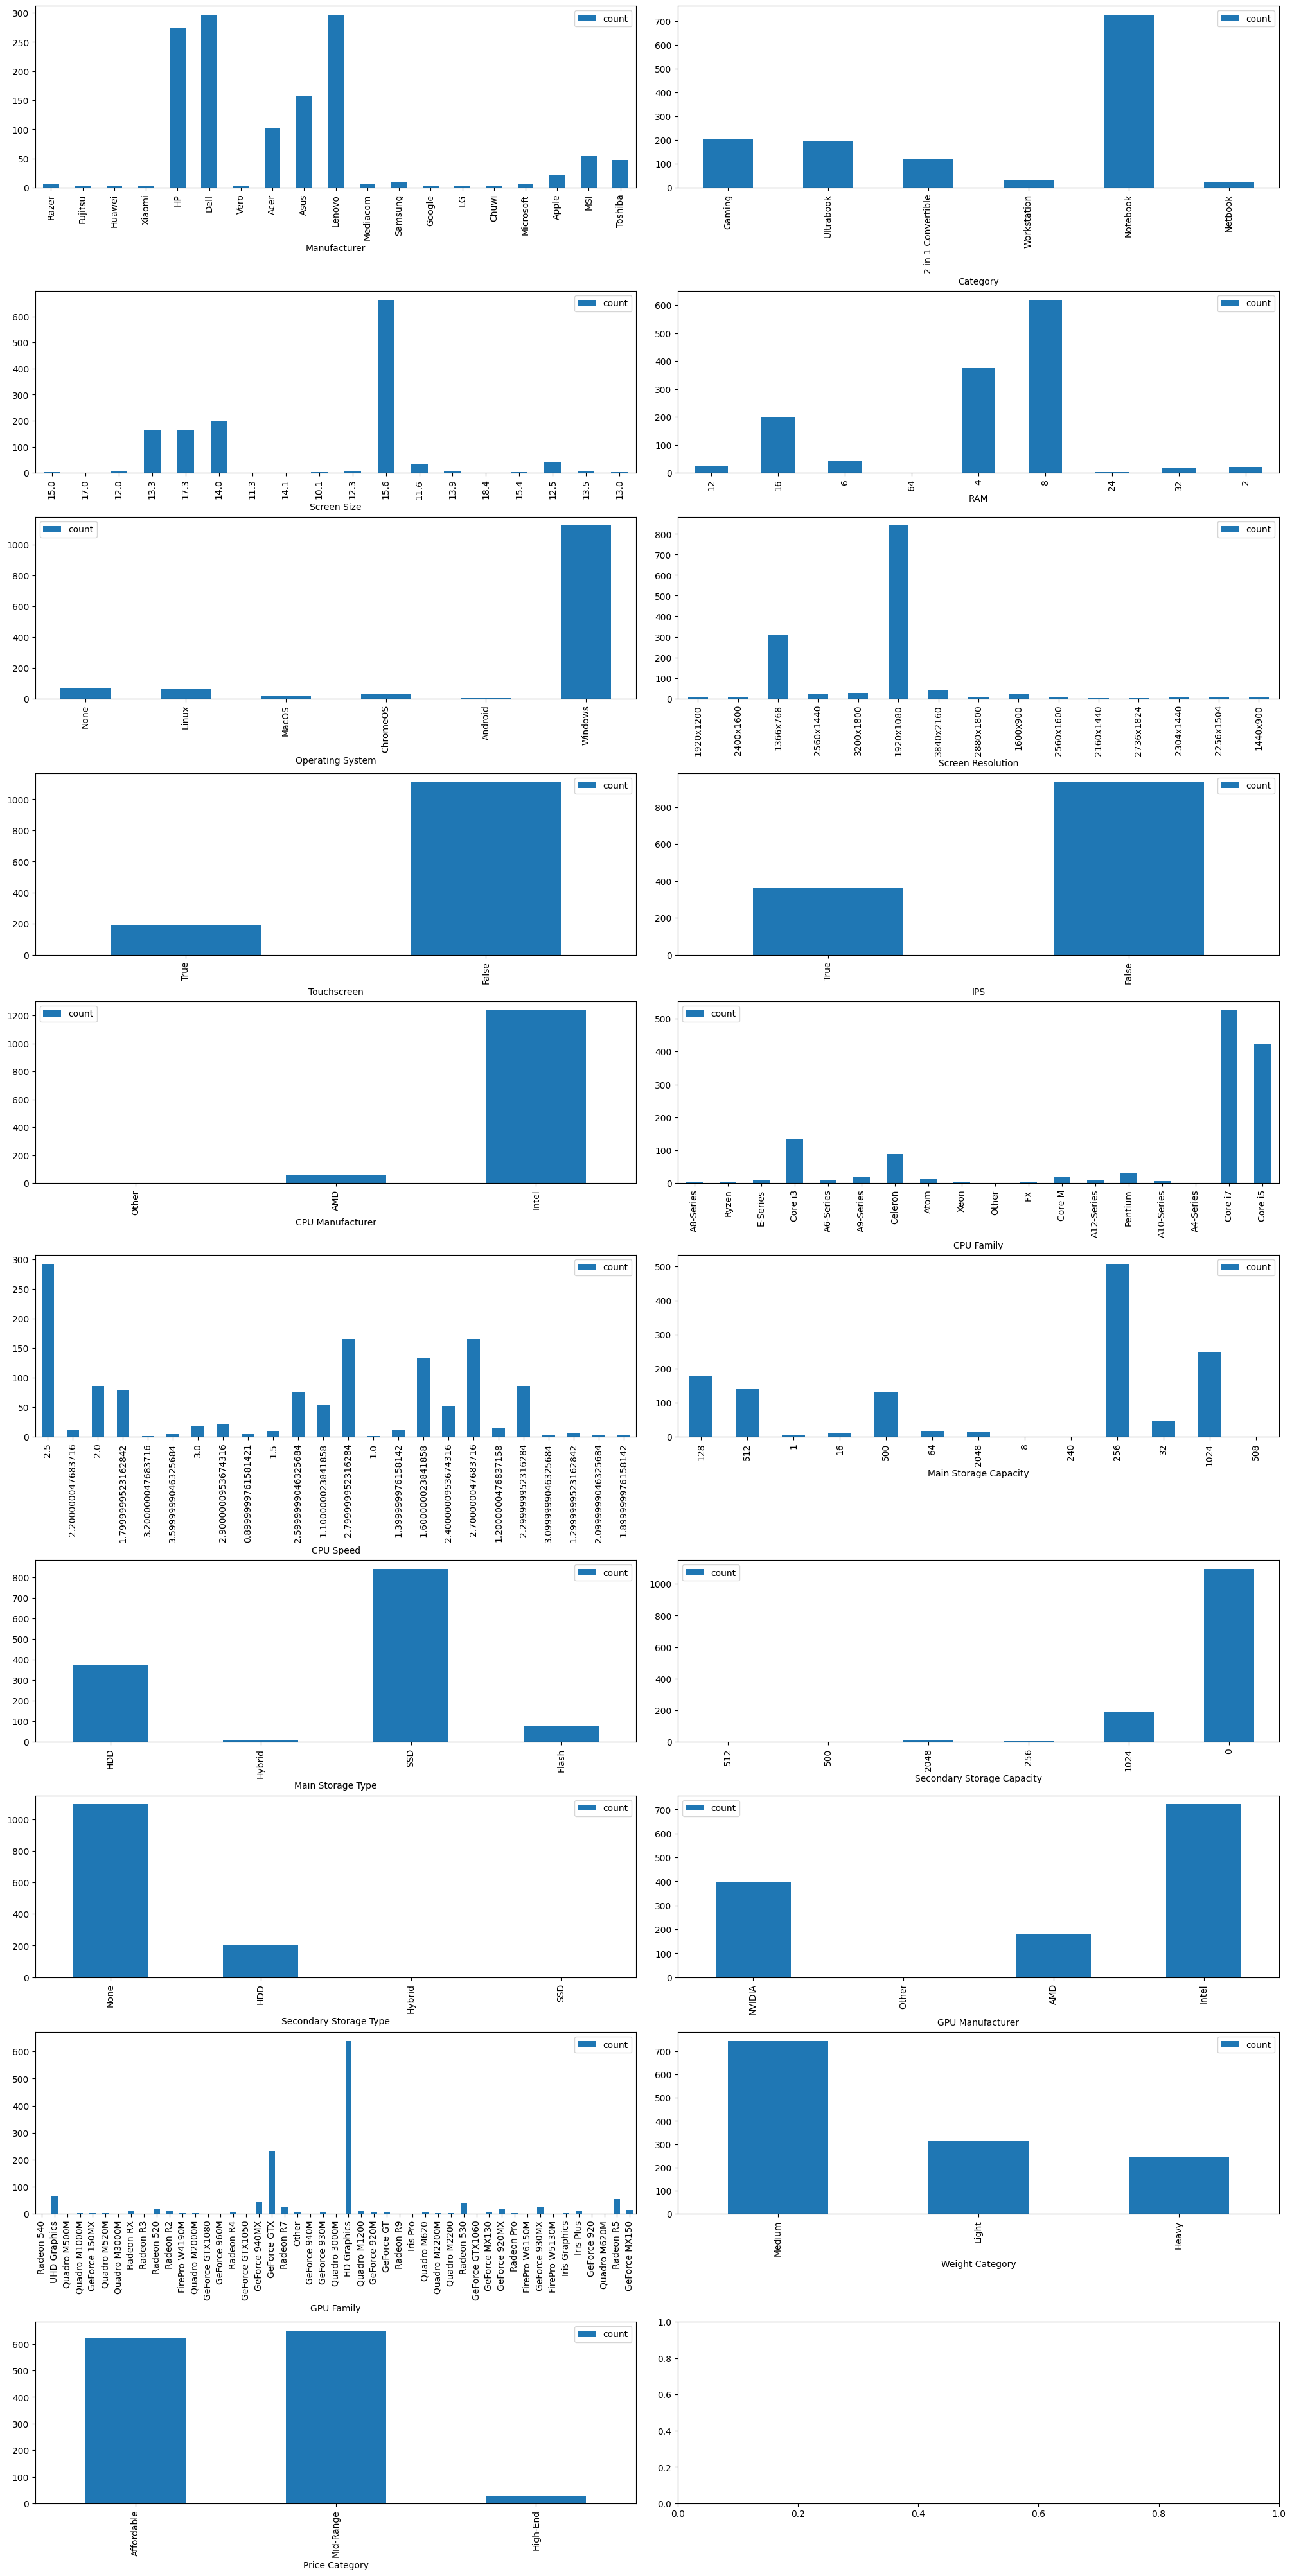

In [255]:
# Create a figure with subplots for each column
fig, ax = plt.subplots(10, 2, figsize=(20, 40), constrained_layout=True)

# Drop the price and weight columns for visualization, the categorical columns will be displayed as bar charts
visualization_data = data.drop("Price", "Weight")

# Plot the data using bar charts
for i, column in enumerate(visualization_data.columns):
    # Determine the subplot to use
    subplot = ax[i//2, i%2]
    # Group the data, convert it to a pandas DataFrame, and plot it
    visualization_data.groupBy(column).count().toPandas().plot(kind='bar', x=column, y='count', ax=subplot)


### 2.2. Correlation matrix

The correlation matrix is a great way to visualize the relationships between numerical variables. In this step, we will plot a correlation matrix for the numerical columns in the dataset. This will help us identify which variables are most correlated with the target variable.

<Axes: >

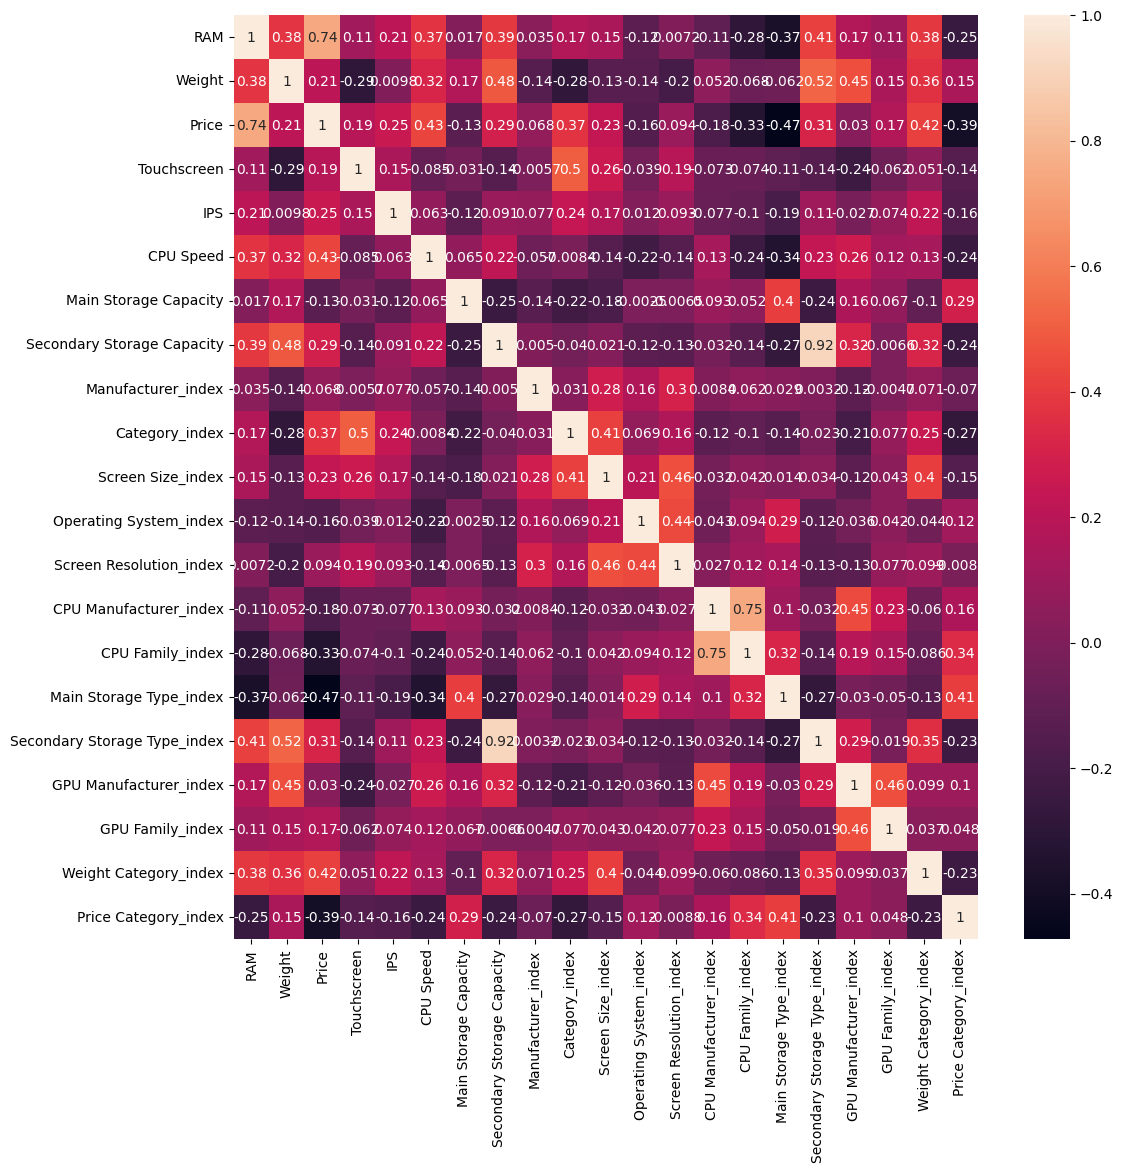

In [256]:
# Create a copy of the data
visualization_data = data

# Select only string columns
string_columns = [c for c in visualization_data.columns if visualization_data.select(c).dtypes[0][1] == 'string']

# Index all the string columns
for c in string_columns:
    indexer = StringIndexer(inputCol=c, outputCol=f"{c}_index")
    visualization_data = indexer.fit(visualization_data).transform(visualization_data).drop(c)

# Plot the correlation matrix of the data
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(visualization_data.toPandas().corr(), annot=True, ax=ax)

## 3. Machine Learning

### 3.1. Data Encoding

Most columns are in a string format after conversion. We need to convert them to numerical format for the machine learning model. In this step, we will encode the categorical variables using the StringIndexer.

In [257]:
# Get all input columns and create output columns
in_columns = [item[0] for item in data.dtypes if item[1].startswith('string')]
out_columns = [item + " Index" for item in in_columns]

# Create the StringIndexer
indexer = StringIndexer(
        inputCols=in_columns,
        outputCols=out_columns)

# Fit the indexer to the data
indexer_model = indexer.fit(data)

# Transform the data
indexed_data = indexer_model.transform(data)

# Replace boolean columns with integer columns
indexed_data = indexed_data.withColumn("Touchscreen", indexed_data["Touchscreen"].cast(IntegerType()))
indexed_data = indexed_data.withColumn("IPS", indexed_data["IPS"].cast(IntegerType()))

# Show the indexed data
indexed_data.show()

+------------+---------+-----------+---+----------------+------+-----+-----------------+-----------+---+----------------+----------+---------+---------------------+-----------------+--------------------------+----------------------+----------------+-------------+---------------+--------------+------------------+--------------+-----------------+----------------------+-----------------------+----------------------+----------------+-----------------------+----------------------------+----------------------+----------------+---------------------+--------------------+
|Manufacturer| Category|Screen Size|RAM|Operating System|Weight|Price|Screen Resolution|Touchscreen|IPS|CPU Manufacturer|CPU Family|CPU Speed|Main Storage Capacity|Main Storage Type|Secondary Storage Capacity|Secondary Storage Type|GPU Manufacturer|   GPU Family|Weight Category|Price Category|Manufacturer Index|Category Index|Screen Size Index|Operating System Index|Screen Resolution Index|CPU Manufacturer Index|CPU Family Ind

### 3.2. Feature selection

Not all columns (features) are relevant for the machine learning model. In this step, we will select the most relevant features and assemble them into a single feature vector.

In [258]:
# Create a VectorAssembler to combine all the features into a single column
assembler = VectorAssembler(
    inputCols=[
        "Manufacturer Index", 
        "Category Index", 
        "Screen Size Index", 
        "RAM", 
        "Operating System Index", 
        "Screen Resolution Index", 
        "Touchscreen", 
        "IPS", 
        "CPU Manufacturer Index", 
        "CPU Family Index", 
        "CPU Speed", 
        "Main Storage Capacity", 
        "Main Storage Type Index", 
        "Secondary Storage Capacity", 
        "Secondary Storage Type Index", 
        "GPU Manufacturer Index",
    ],
    outputCol="features"
)

# Create a DataFrame with only the features and the labels for linear and logistic regression
ml_data = assembler.transform(indexed_data) \
    .withColumn("linear_label", col("Price")) \
    .withColumn("logistic_label", col("Price Category Index")) \
    .select("features", "linear_label", "logistic_label")

# Show the machine learning data
ml_data.show()

+--------------------+------------+--------------+
|            features|linear_label|logistic_label|
+--------------------+------------+--------------+
|[7.0,2.0,2.0,8.0,...|         714|           0.0|
|[7.0,2.0,2.0,8.0,...|         479|           1.0|
|(16,[0,3,4,9,10,1...|         306|           1.0|
|[7.0,2.0,12.0,16....|        1353|           0.0|
|[7.0,2.0,2.0,8.0,...|         962|           0.0|
|(16,[0,3,5,8,9,10...|         213|           1.0|
|[7.0,2.0,12.0,16....|        1141|           0.0|
|[7.0,2.0,2.0,8.0,...|         618|           0.0|
|(16,[0,1,2,3,10,1...|         797|           0.0|
|(16,[0,1,2,3,7,9,...|         410|           1.0|
|(16,[0,3,4,5,9,10...|         210|           1.0|
|(16,[0,3,4,9,10,1...|         184|           1.0|
|[7.0,2.0,12.0,16....|        1301|           0.0|
|(16,[3,9,10,11,15...|         266|           1.0|
|[7.0,2.0,6.0,8.0,...|         673|           0.0|
|[7.0,2.0,2.0,8.0,...|         810|           0.0|
|(16,[3,10,11,15],...|         

### 3.3. Splitting the data

To train and evaluate the machine learning model, we need to split the data into training and testing sets. In this step, we will split the data into 80% training and 20% testing.

In [259]:
# Split the data into training and testing sets
train, test = ml_data.randomSplit([0.8, 0.2])
# Show the number of rows in the training and testing sets
train.count(), test.count()

(1034, 268)

### 3.4. Linear Regression

Linear regression is a simple machine learning model that predicts a continuous value. In this step, we will train a linear regression model on the training data and evaluate it on the testing data.

In [260]:
# Create a Linear Regression model
linear_regression = LinearRegression(featuresCol="features", labelCol="linear_label", maxIter=10000)

# Fit the model to the training data
linear_model = linear_regression.fit(train)

In [261]:
# Show the coefficients of the model
linear_model.coefficients

DenseVector([2.1524, 63.1911, 7.6508, 38.0587, -47.934, 34.4066, -34.9117, 28.1696, -260.6254, 9.1232, 146.731, -0.004, -91.1441, 0.0094, 1.8102, -2.8103])

In [262]:
# Show the intercept of the model
linear_model.intercept

-107.23601655350521

In [263]:
# Evaluate the model on the testing data
linear_results = linear_model.evaluate(test)

In [264]:
# Show the predictions and residuals (difference between the actual and predicted values) for the first 100 rows
linear_results.predictions.withColumn("residuals", col("linear_label") - col("prediction")).show(n=100)

+--------------------+------------+--------------+------------------+-------------------+
|            features|linear_label|logistic_label|        prediction|          residuals|
+--------------------+------------+--------------+------------------+-------------------+
|(16,[0,1,2,3,4,10...|         506|           0.0| 658.9612120849832|-152.96121208498323|
|(16,[0,1,2,3,5,6,...|         253|           1.0| 662.4781247099193|-409.47812470991926|
|(16,[0,1,2,3,5,6,...|         581|           0.0| 795.5751196940554| -214.5751196940554|
|(16,[0,1,2,3,5,6,...|         613|           0.0| 806.6707453482406|-193.67074534824064|
|(16,[0,1,2,3,5,6,...|         746|           0.0|1174.3313422143053| -428.3313422143053|
|(16,[0,1,2,3,5,6,...|        2933|           2.0|1672.8547797274448| 1260.1452202725552|
|(16,[0,1,2,3,5,7,...|         719|           0.0|1312.1925481382189| -593.1925481382189|
|(16,[0,1,2,3,5,7,...|        1217|           0.0| 927.7288924238375| 289.27110757616254|
|(16,[0,1,

### 3.5. Logistic Regression

Logistic regression is a simple machine learning model that predicts a categorical value. In this step, we will train a logistic regression model on the training data and evaluate it on the testing data.

In [265]:
# Create a Logistic Regression model
logistic_regression = LogisticRegression(featuresCol="features", labelCol="logistic_label", maxIter=10000)

# Fit the model to the training data
logistic_model = logistic_regression.fit(train)

In [266]:
# Evaluate the model on the testing data
logistic_results = logistic_model.evaluate(test)

In [267]:
# Create a column with the correct predictions (1 if the prediction is correct, 0 otherwise)
logistic_results.predictions.withColumn("correct", when(col("logistic_label") == col("prediction"), 1).otherwise(0))

DataFrame[features: vector, linear_label: int, logistic_label: double, rawPrediction: vector, probability: vector, prediction: double, correct: int]

In [268]:
# Calculate the True Positive, True Negative, False Positive, and False Negative counts
TP = logistic_results.predictions.filter("logistic_label = 0 AND prediction = 0").count()
TN = logistic_results.predictions.filter("logistic_label = 1 AND prediction = 1").count()
FP = logistic_results.predictions.filter("logistic_label = 1 AND prediction = 0").count()
FN = logistic_results.predictions.filter("logistic_label = 0 AND prediction = 1").count()

In [269]:
# Accuracy is the proportion of correct predictions
accuracy = (TP + TN) / (TP + TN + FP + FN)
accuracy

0.8365758754863813

In [270]:
# Recall is the ratio of true positive predictions to the total number of actual positive values
recall = TP / (TP + FN)
recall

0.9016393442622951

In [428]:
# Precision is the ratio of true positive predictions to the total number of positive predictions
precision = TP / (TP + FP)
precision

0.918918918918919